<a href="https://colab.research.google.com/github/samurai921/task_sklearn/blob/master/task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача 3. Детектирование токсичных комментариев

Вам будет предоставлен корпус размеченных (0 - не токсик, 1 - токсик) текстов, где тексты представляют собой комментарии. Необходимо выполнить их семантический анализ и классифицировать на позитивные и негативные (токсичные).

Задачу можно решить как минимум двумя способами: классической текстовой моделью TF-IDF или с помощью нейронок типа BERT трансформера (суть таких нейронок в общем схожа - они делают эмбендинги слов - верктоные представления)

В качестве метрики используйте f1-меру

полезные источники:

https://habr.com/ru/companies/otus/articles/755772/

https://habr.com/ru/articles/446530/

https://habr.com/ru/companies/otus/articles/702838/


# Импортируем необходимые библиотеки

Импорт основных библиотек

In [40]:
import os
import re
from collections import Counter
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

warnings.filterwarnings('ignore')

In [41]:
# !pip install catboost

In [42]:
# !pip install sentence_transformers

Импорт спец. библиотек

In [43]:
import nltk
from tqdm import tqdm
from wordcloud import WordCloud
from nltk.util import bigrams, ngrams
import tensorflow as tf
from nltk.corpus import wordnet
from catboost import CatBoostClassifier
from pymystem3 import Mystem
from sentence_transformers import SentenceTransformer

импорт элементов библиотеки Scikit-Learn

In [44]:
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

## Подготовка данных

откроем и изучим файл

In [45]:
df = pd.read_csv('toxic_comments.csv', names=['text','toxic'], skiprows=[0])

In [46]:
# from google.colab import drive
# drive.mount('/content/drive')

In [47]:
df.head()

,text,toxic
0,Explanation\r\nWhy the edits made under my use...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\r\nMore\r\nI can't make any real suggestions...",0
4,"You, sir, are my hero. Any chance you remember...",0


Проверим типы данных

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [49]:
df.describe()

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Итог
Датасет содержит почти 160 тыс. комментариев.

## Тип данных
Тип данных соответствует содержанию в колонка.

## Пропуски и дубликаты
Пропуски и дубликаты - отсутствуют.


## Рассмотрим распределение позитивных и негативных коментрариев

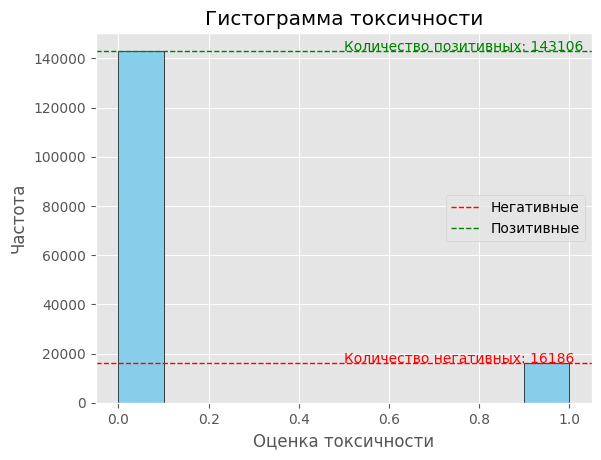

In [50]:
# Используем стиль ggplot для более привлекательного внешнего вида
plt.style.use('ggplot')

# Построение гистограммы
plt.hist(df['toxic'], bins=10, color='skyblue', edgecolor='black')

# Добавление заголовка и меток осей на русском языке
plt.title('Гистограмма токсичности')
plt.xlabel('Оценка токсичности')
plt.ylabel('Частота')

# Добавление уровней для отметки количества токсичных и нетоксичных комментариев
toxic_count = df[df['toxic'] == 1]['toxic'].count()
non_toxic_count = df[df['toxic'] == 0]['toxic'].count()

plt.axhline(toxic_count, color='red', linestyle='--', linewidth=1, label='Негативные')
plt.axhline(non_toxic_count, color='green', linestyle='--', linewidth=1, label='Позитивные')

# Добавление текста с количеством над каждой линией
plt.text(0.5, toxic_count + 10, f'Количество негативных: {toxic_count}', color='red', fontsize=10)
plt.text(0.5, non_toxic_count + 10, f'Количество позитивных: {non_toxic_count}', color='green', fontsize=10)

# Добавление легенды
plt.legend()

# Добавление сетки для лучшей читаемости
plt.grid(True)

# Отображение гистограммы
plt.show()


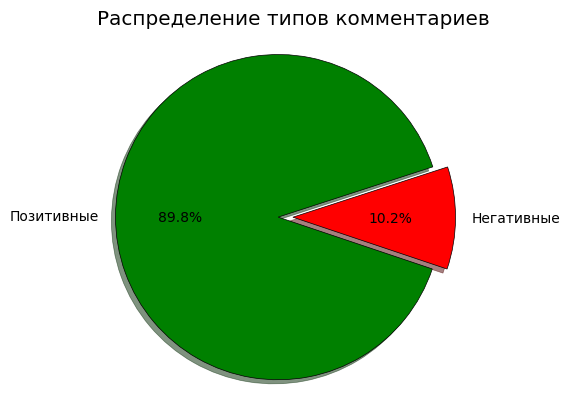

In [51]:
# Используем стиль ggplot для более привлекательного внешнего вида
plt.style.use('ggplot')

# Распределение токсичности комментариев на круговой диаграмме
plt.pie(df['toxic'].value_counts(),
        labels=['Позитивные', 'Негативные'],
        autopct='%1.1f%%',
        startangle=18,
        explode=(0.1, 0),  # добавляем небольшое расстояние между сегментами
        shadow=True,
        colors=['green', 'red'],  # цвета для позитивных и негативных комментариев соответственно
        wedgeprops={'edgecolor': 'black'},  # добавляем черную границу для каждого сегмента
        radius=1.10)
plt.title('Распределение типов комментариев')

# Отображение круговой диаграммы
plt.show()

## Итог

Присутствует дисбаланс классов: позитивных комментариев больше в 9 раз.


## Длина комментариев

In [52]:
df['comment_length'] = df['text'].str.len()

In [53]:
df['comment_length'].describe()

count    159292.000000
mean        396.211618
std         593.777170
min           5.000000
25%          96.000000
50%         207.000000
75%         437.000000
max        5000.000000
Name: comment_length, dtype: float64

Посмотрим на распределение длины комментариев в обучающей и тестовой выборках:

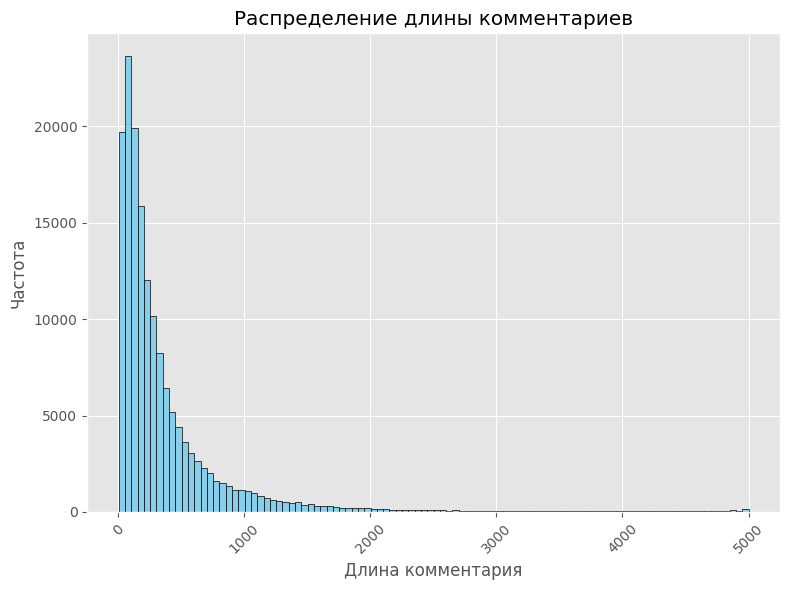

In [54]:
# Используем стиль ggplot для более привлекательного внешнего вида
plt.style.use('ggplot')

# Создание объекта Figure и осей
fig, ax = plt.subplots(figsize=(8, 6))

# Название графика и построение гистограммы
title = 'Распределение длины комментариев'
df['comment_length'].hist(ax=ax, bins=100, color='skyblue', edgecolor='black')

# Установка заголовка и меток осей
ax.set(title=title, xlabel='Длина комментария', ylabel='Частота')

# Добавление сетки для лучшей читаемости
ax.grid(True)

# Уменьшение перекрытия меток оси x
plt.xticks(rotation=45)

# Подгонка макета
plt.tight_layout()

# Отображение графика
plt.show()

## Посмотрим на распределение длины негативных и позитивных комментариев:

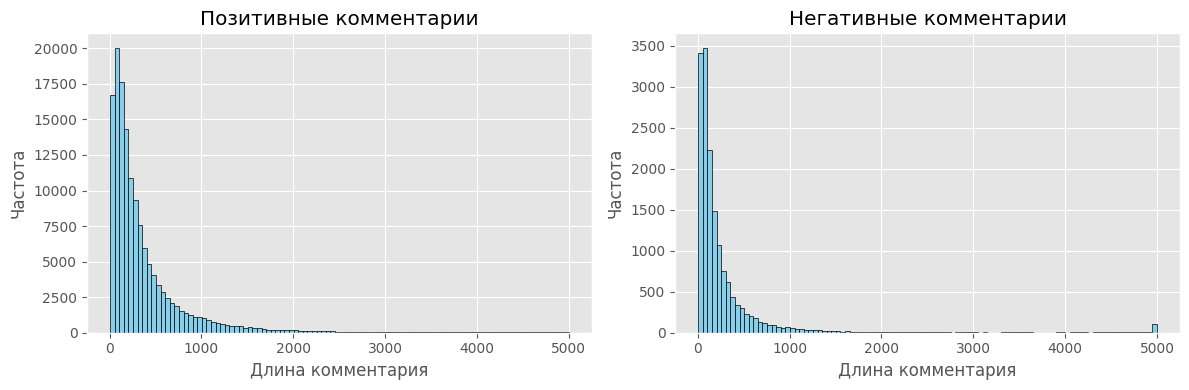

In [55]:
# Используем стиль ggplot для более привлекательного внешнего вида
plt.style.use('ggplot')

# Создание фигуры и осей
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Построение гистограмм для позитивных и токсичных комментариев
for i, title in enumerate(['Позитивные', 'Негативные']):
    df[df['toxic'] == i]['comment_length'].hist(ax=ax[i], bins=100, color='skyblue', edgecolor='black')
    ax[i].set(title=title + ' комментарии', xlabel='Длина комментария', ylabel='Частота')
    ax[i].grid(True)  # Добавление сетки

# Установка отступов между графиками
plt.tight_layout()

# Отображение гистограмм
plt.show()

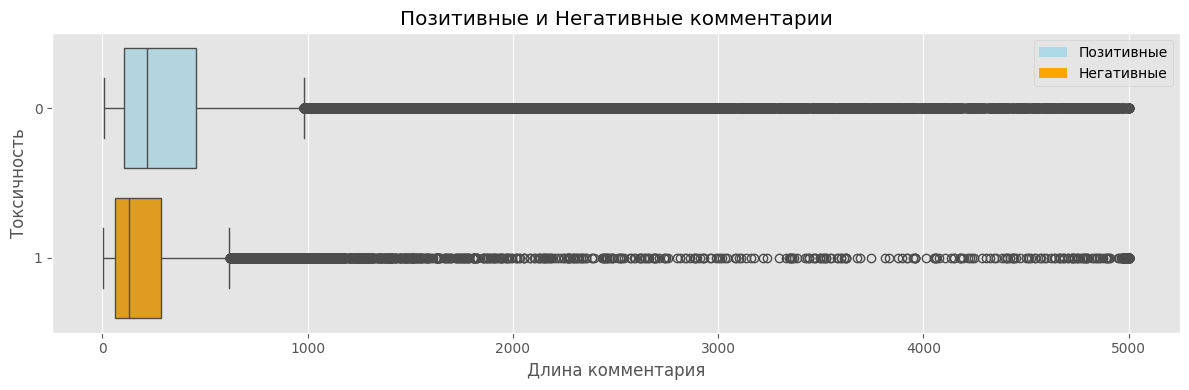

In [56]:
# Создание фигуры и осей
fig, ax = plt.subplots(figsize=(12, 4))

# Создание ящиковых графиков для позитивных и негативных комментариев
sns.boxplot(y='toxic', x='comment_length', orient='h', data=df, ax=ax, palette=['lightblue', 'orange'])

# Установка заголовка и меток осей
ax.set(title='Позитивные и Негативные комментарии', xlabel='Длина комментария', ylabel='Токсичность')

# Добавление легенды

legend_elements = [Patch(facecolor='lightblue', label='Позитивные'),
                   Patch(facecolor='orange', label='Негативные')]
ax.legend(handles=legend_elements)

# Подгонка макета
plt.tight_layout()

# Отображение графика
plt.show()

## Итог:

Отсутствуют серьезные различия в длине позитивных и негативных комментариев.

# TF-IDF (CPU)

Самый примитивны способ: использовать только слова встречаемые в исходном тексте. Обучение и предсказание происходит только на словаре, который сформировывается из слов комментариев.

Оцифровка слов происходит за счёт подсчёта их важности, величиной TF-IDF. То есть TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе.

Примечание: бóльшая величина TF-IDF говорит об уникальности слова в тексте по отношению к корпусу. Чем чаще оно встречается в конкретном тексте и реже в остальных, тем выше значение TF-IDF.

In [57]:
# инициализация класса для лемматизации
WNLemmatizer = nltk.stem.WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# функция определение части речи
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# функция лемматизации и очистки текста
def lemm_clear_text(text):
    word_list = nltk.word_tokenize(text)
    lemm_text = ' '.join([WNLemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_list])
    lemm_text = re.sub(r"[a-zA-Z]+'?[a-zA-Z]+", '', lemm_text)
    lemm_text = lemm_text.split()
    lemm_clear_text =  ' '.join(lemm_text)
    return lemm_clear_text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [58]:
# df['lemm_text'] = ""

# for index, row in tqdm(df.iterrows(), total=len(df)):

#     df.at[index, 'lemm_text'] = lemm_clear_text(row['text'])

In [59]:
# df.to_csv('test_preprocessed.csv', index=False)

In [60]:
read_test_df = pd.read_csv('test_preprocessed.csv')



In [61]:
print('Исходный текст:', read_test_df.loc[1, 'text'])
print('Лемматизированный:', read_test_df.loc[1, 'lemm_text'])

Исходный текст: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Лемматизированный: Daww He match this background colour I m seemingly stuck with Thanks talk January UTC


После лемматизации теста появились пропусти. Это комментарии состоящие только из цифр и символов. Для них не существуют леммы, и следовательно результатом лемматизации будет: NaN. Пример этих объектов приведён ниже. В дальнейгей работе они использованы не будут.

In [62]:
read_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   text            159292 non-null  object
 1   toxic           159292 non-null  int64 
 2   comment_length  159292 non-null  int64 
 3   lemm_text       159281 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.9+ MB


In [63]:
anomaly_index = read_test_df[(read_test_df['lemm_text'].isna()) | (read_test_df['lemm_text']=='')].index
display(read_test_df.loc[anomaly_index])
read_test_df.drop(index=anomaly_index, inplace=True)
read_test_df.reset_index(drop=True, inplace=True)

,text,toxic,comment_length,lemm_text
4475,1993\n\n1994\n\n1995\n\n1996\n\n1997\n\n1998\n...,0,64,NaN
6289,193.61.111.53 15:00,0,20,NaN
10193,"64.86.141.133""",0,14,NaN
17280,~ \n\n68.193.147.157,0,18,NaN
38743,"88.104.31.21""",0,13,NaN
52336,"14:53,",0,6,NaN
53679,92.24.199.233|92.24.199.233]],0,29,NaN
61644,"""\n\n 199.209.144.211 """,0,22,NaN
82541,"""\n '''''' 2010/2013 """,0,21,NaN
119018,"""""""",1,5,NaN


## Биграммы и триграммы

In [64]:
read_test_df['toxic'] = read_test_df['toxic'].map({0: 'Позитивные', 1: 'Негативные'})

In [65]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

# создание TF-IDF векторизатора с стоп словами (слова без смысловой нагрузки)
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [66]:
for n, name in zip([2, 3], ['Биграммы', 'Триграммы']):
    for is_clear, title in enumerate(['Негативные', 'Позитивные']):
        all_ngrams = []

        # Извлечение n-грамм из комментариев
        for words_list in read_test_df[read_test_df['toxic'] == title]['lemm_text']:
            all_ngrams.extend((list(ngrams(words_list.split(), n))))

        # Вывод наиболее часто встречающихся n-грамм
        print('{} - {} комментарии:'.format(name, title))
        print(pd.Series(all_ngrams).value_counts()[:10])
        print('\n')

Биграммы - Негативные комментарии:
(be, a)             5252
(do, nt)            2922
(I, be)             2284
(you, be)           2231
(FUCK, YOU)         1885
(NIGGER, NIGGER)    1882
(of, the)           1590
(moron, hi)         1474
(hi, moron)         1472
(I, m)              1423
dtype: int64


Биграммы - Позитивные комментарии:
(of, the)         47822
(in, the)         33908
(be, a)           30776
(do, nt)          28964
(to, the)         25238
(it, be)          24743
(be, not)         23868
(the, article)    22716
(on, the)         21251
(to, be)          20135
dtype: int64


Триграммы - Негативные комментарии:
(NIGGER, NIGGER, NIGGER)    1876
(hi, moron, hi)             1468
(moron, hi, moron)          1466
(faggot, faggot, faggot)    1334
(PIG, PIG, PIG)             1248
(FAT, JEW, FAT)             1226
(JEW, FAT, JEW)             1224
(Bark, Bark, Bark)           998
(SHIT, SHIT, SHIT)           998
(WANKER, WANKER, WANKER)     940
dtype: int64


Триграммы - Позитивные коммен

## Облако слов  

Разделим позитивные и негативные комметарии

In [67]:
toxic_text = " ".join(read_test_df[read_test_df['toxic'] == 'Негативные'].text.tolist())
clear_text = " ".join(read_test_df[read_test_df['toxic'] == 'Позитивные'].text.tolist())

In [68]:
def clean_and_tokenize(text):

    words = re.findall(r'\b\w+\b', text.lower())
    return words


toxic_words = clean_and_tokenize(toxic_text)
clear_words = clean_and_tokenize(clear_text)

toxic_word_counts = Counter(toxic_words)
clear_word_counts = Counter(clear_words)


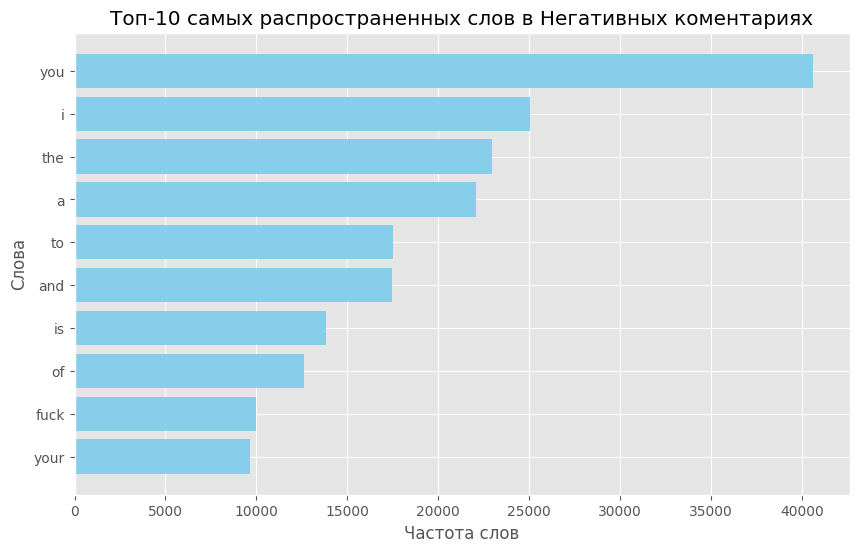

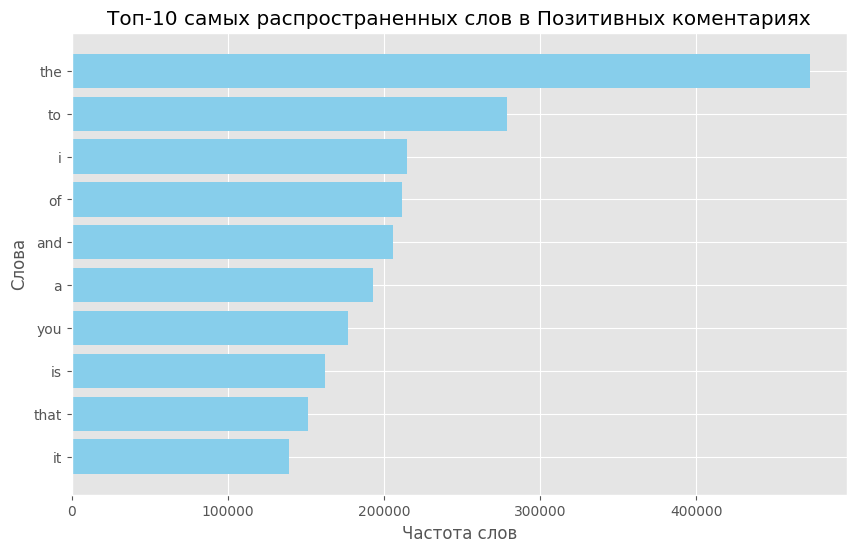

In [69]:
def plot_word_counts(word_counts, title):

    sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)


    top_words = [word[0] for word in sorted_word_counts[:10]]
    top_counts = [word[1] for word in sorted_word_counts[:10]]


    plt.figure(figsize=(10, 6))
    plt.barh(top_words, top_counts, color='skyblue')
    plt.xlabel('Частота слов')
    plt.ylabel('Слова')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()


plot_word_counts(toxic_word_counts, 'Топ-10 самых распространенных слов в Негативных коментариях')

plot_word_counts(clear_word_counts, 'Топ-10 самых распространенных слов в Позитивных коментариях')


Зададим параметры для построения облака слов.

NameError: name 'cm' is not defined

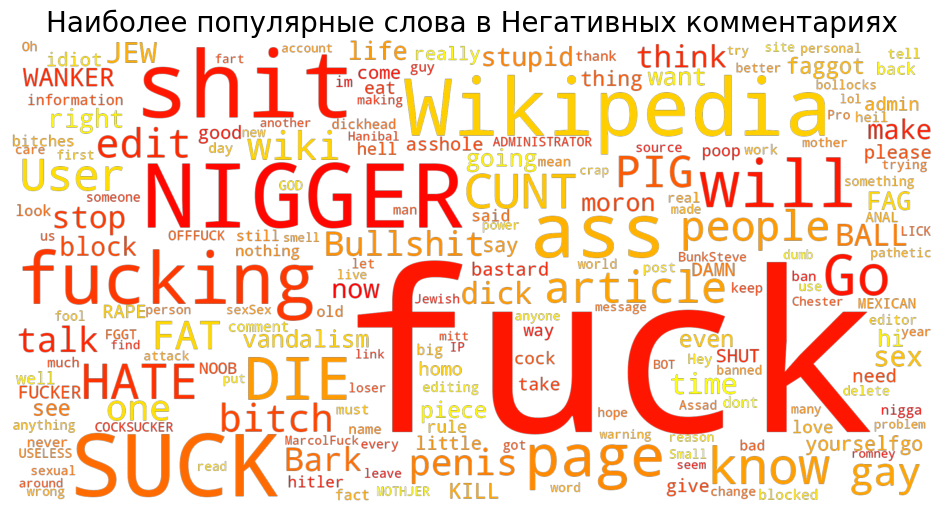

In [39]:
import matplotlib.cm as cm


cloud_params = {
    'max_words': 200,
    'regexp': "[a-zA-Z]+'?[a-zA-Z]+",
    'collocations': False,
    'width': 2400,
    'height': 1200,
    'margin': 5,

    'relative_scaling': 1,
    'prefer_horizontal': 1,
    'min_font_size': 20,
    'font_step': 2,

    'background_color': None,
    'mode': 'RGBA',

    'random_state': 42
}

texts = [toxic_text, clear_text]
cmaps = ['autumn', 'winter']
titles = ['Негативных', 'Позитивные']

for text, cmap, title in zip(texts, cmaps, titles):
    word_cloud = WordCloud(colormap=cmap, **cloud_params)
    word_cloud.generate(text)

    # Получаем частоты слов
    frequencies = word_cloud.words_

    plt.figure(figsize=(12, 6))
    plt.axis('off')
    plt.title('Наиболее популярные слова в {} комментариях'.format(title), fontsize=20)
    plt.imshow(word_cloud, interpolation='bilinear', cmap=cmap)

    # Визуализируем цветовую шкалу с числовыми метками
    cb = plt.colorbar(cm.ScalarMappable(cmap=cmap), ax=plt.gca(), orientation='vertical')
    cb.set_label('Частота слов')

    # Определяем максимальное значение частоты для меток
    max_freq = max(frequencies.values())
    # Устанавливаем метки шкалы в соответствии с максимальным значением частоты
    cb.set_ticks([0, max_freq])

    plt.tight_layout()
    plt.show()


## Построение модели

In [70]:
RANDOM_STATE = 42
FIG_SIZE = (7, 6)

In [71]:
read_test_df['toxic'] = read_test_df['toxic'].replace({'Позитивные': 0, 'Негативные': 1})

In [72]:
# скачивание стоп слов
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

# создание TF-IDF векторизатора с стоп словами (слова без смысловой нагрузки)
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
# подготовка обучающей выборки
target = read_test_df['toxic']
features = read_test_df['lemm_text']

# выделение тренировочной выборки
X_train_tfidf, X_other, Y_train_tfidf, Y_other = train_test_split(features,
                                                                  target,
                                                                  stratify = target,
                                                                  train_size = 0.80,
                                                                  random_state = RANDOM_STATE)
# выделение валидационной и тестовой выборок
X_valid_tfidf, X_test_tfidf, Y_valid_tfidf, Y_test_tfidf = train_test_split(X_other,
                                                                            Y_other,
                                                                            stratify = Y_other,
                                                                            test_size = 0.50,
                                                                            random_state = RANDOM_STATE)

In [74]:
# "кодирование" текста
count_tf_idf.fit(X_train_tfidf)
X_train_tfidf = count_tf_idf.transform(X_train_tfidf)
X_valid_tfidf = count_tf_idf.transform(X_valid_tfidf)
X_test_tfidf  = count_tf_idf.transform(X_test_tfidf)

print('Количество признаков:', X_train_tfidf.shape[1])

Количество признаков: 169062


Далее следует тестирование преобразованного текста. Поскольку в датасете присутствует дисбаланс, а целевая метрика F1 демонстрирует условную параллельность Recall и Precision. В дополнении к ней будет выводится значение этих метрик и применяться построение PR-кривой и значения порогов классификации.

Для оценки качества преобразования, закодированный текст сразу будет тестироваться на следующих моделях классификации:

LogisticRegression;
CatBoostClassifier.

## LogisticRegression

In [75]:
# объявление модели Логистической регрессии и её гиперпараметров
LogRer_tfidf = LogisticRegression(C = 11.5,
                                  solver = 'sag',
                                  random_state = RANDOM_STATE)

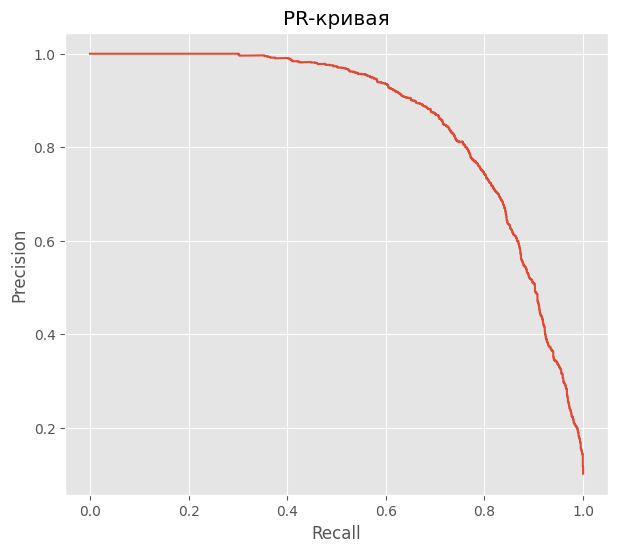

F1 = 0.773
Recall = 0.691
Precision = 0.878


In [76]:
# тестирование TF-IDF на Logistic Regression
LogRer_tfidf.fit(X_train_tfidf, Y_train_tfidf)
prediction_valid = LogRer_tfidf.predict(X_valid_tfidf)
proba_valid = LogRer_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, prediction_valid)))

## CatBoost


In [77]:
# модель градиентного бустинга CatBoost (CPU) 16 minutes
CatBoost_tfidf = CatBoostClassifier(verbose = 100, # шаг вывода информации о процессе обучения
                                    task_type = 'CPU', # среда работы модели
                                    max_depth = 5, # макс. глубина базовых моделей
                                    learning_rate = 0.9, # шаг градиентного бустинга
                                    eval_metric = 'F1') # метрика оценки модели

In [78]:
# обучение CatBoost на фичах TF-IDF
CatBoost_tfidf.fit(X_train_tfidf, Y_train_tfidf)

0:	learn: 0.4062195	total: 1.6s	remaining: 26m 42s
100:	learn: 0.8013845	total: 2m 32s	remaining: 22m 38s
200:	learn: 0.8316807	total: 5m 1s	remaining: 19m 58s
300:	learn: 0.8458307	total: 7m 29s	remaining: 17m 23s
400:	learn: 0.8485454	total: 9m 56s	remaining: 14m 50s
500:	learn: 0.8510904	total: 12m 26s	remaining: 12m 23s
600:	learn: 0.8665233	total: 14m 54s	remaining: 9m 54s
700:	learn: 0.8852916	total: 17m 24s	remaining: 7m 25s
800:	learn: 0.9035269	total: 19m 55s	remaining: 4m 57s
900:	learn: 0.9203170	total: 22m 36s	remaining: 2m 29s
999:	learn: 0.9368140	total: 25m 5s	remaining: 0us


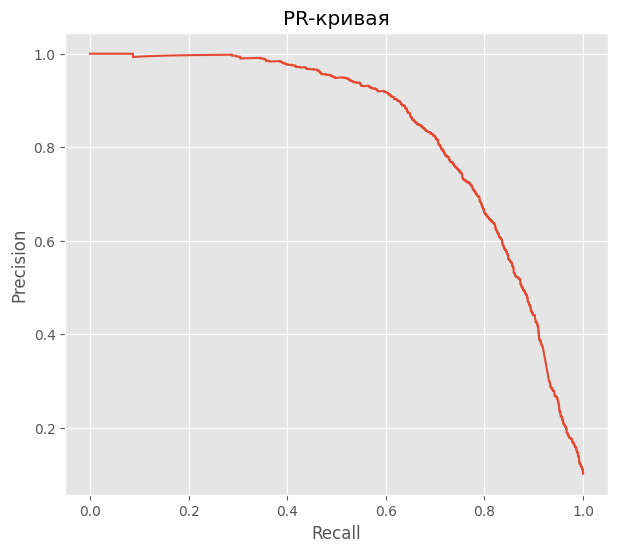

F1 = 0.749
Recall = 0.675
Precision = 0.842


In [79]:
# тестирование TF-IDF на CatBoost
prediction_valid = CatBoost_tfidf.predict(X_valid_tfidf)
proba_valid = CatBoost_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, prediction_valid)))

## Итог:

Лемматизация текста занимает около 5 часов. На этот процесс не влияет применение графического процессора.

Процесс векторизации подготовленного текста с помощью TfidfVectorizer - мгновенный. Слова, не имеющие смысловой нагрузки - удалены.

Логистическая регрессия имеет значение целевой метрики F1 = 0.773

Градиентный бустинг CatBoost F1 = 0.752. Время обучения на CPU 3.5 минут

Ключевым недостатком является большое количество признаков и объём памяти, которую они занимают. Это затрудняет использование GPU, к примеру для ускорения обучения модели CatBoost.


На данном этапе результат тестирования - приемлемый. Но необходимо учесть присутствующий дисбалланс классов. Этой теме будет посвящен отдельный раздел.

## SentanceTranformer (GPU)

В этом разделе будет применён альтернативный способ преобразования. TF-IDF векторизатор не учитывает контекст в отличии от предобученной модели для SentanceTranformer. Она позволяет создавать эбеддинги (вектора), которые сохраняют контекст комментариев.

Меньшее количество признаков и требуемый объём ОП позволяет применять GPU и ускорять процесс работы с большим объёмом данных.

In [80]:
# инициализация предобученной модели преобразования текста в вектора
sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [81]:
# назначение GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [82]:
%%time
# кодирование текста
ST_embeddings = []

if  device_name == '/device:GPU:0':
    with tf.device('/device:GPU:0'):
        ST_embeddings = sentence_transformer.encode(read_test_df['text'])
else:
    for i in tqdm(range(len(read_test_df['text']))):
        ST_embeddings.append(sentence_transformer.encode(read_test_df.loc[i, 'text']))

CPU times: user 3min 42s, sys: 1.85 s, total: 3min 44s
Wall time: 3min 25s


In [83]:
pd.DataFrame(ST_embeddings).head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.028033,0.056780,0.091350,0.032315,0.048531,0.024905,-0.001665,-0.035811,0.015926,-0.019791,...,-0.001887,0.004119,0.005928,0.077336,-0.058341,-0.031362,0.001371,0.014139,-0.026163,-0.041901
1,-0.051320,0.087537,0.055453,-0.061086,0.071453,-0.035208,0.104684,-0.090926,-0.009080,-0.010960,...,0.082233,-0.088611,0.035271,0.029772,0.046203,0.039858,0.092982,0.020118,-0.092164,0.018549
2,0.010958,0.092103,0.051115,0.013316,0.018948,0.023738,-0.033800,-0.098386,0.031458,0.026289,...,-0.015570,0.027781,0.109071,0.068101,0.047131,0.015144,0.022232,-0.060034,0.014200,0.009034
3,-0.009012,-0.036221,0.051822,0.067826,0.083256,0.101421,-0.041176,0.040358,-0.090684,0.007777,...,0.019424,0.046546,0.025812,-0.015300,0.046243,-0.013108,0.030476,0.031271,0.016119,0.054877
4,-0.108289,-0.002620,-0.120247,-0.031936,0.018257,0.051597,-0.008284,-0.025604,-0.056420,0.014543,...,-0.022339,-0.015537,0.059215,-0.016928,0.009169,-0.014318,0.112808,0.089494,-0.086648,-0.038295


In [84]:
# подготовка обучающей выборки
target = read_test_df['toxic']
features = ST_embeddings

# выделение тренировочной выборки
X_train_emb, X_other, Y_train_emb, Y_other = train_test_split(features,
                                                              target,
                                                              stratify = target,
                                                              train_size = 0.80,
                                                              random_state = RANDOM_STATE)
# выделение валидационной и тестовой выборок
X_valid_emb, X_test_emb, Y_valid_emb, Y_test_emb = train_test_split(X_other,
                                                                    Y_other,
                                                                    stratify = Y_other,
                                                                    test_size = 0.50,
                                                                    random_state = RANDOM_STATE)

print('Количество признаков:', X_train_emb.shape[1])

Количество признаков: 384


## LogisticRegression

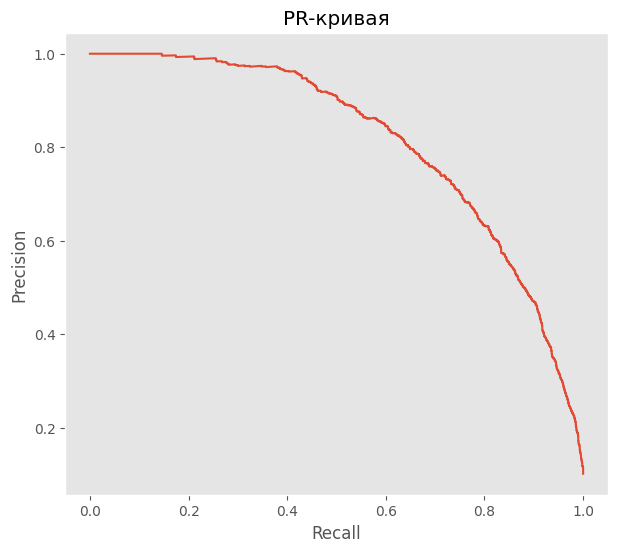

F1 = 0.703
Recall = 0.609
Precision = 0.831


In [85]:
# тестирование SentanceTranformer на Logistic Regression
LogRer_emb = LogisticRegression(solver = 'sag', random_state = RANDOM_STATE)
LogRer_emb.fit(X_train_emb, Y_train_emb)
prediction_valid = LogRer_emb.predict(X_valid_emb)
proba_valid = LogRer_emb.predict_proba(X_valid_emb)
precision, recall, thresholds = precision_recall_curve(Y_valid_emb, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_emb, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_emb, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_emb, prediction_valid)))

## CatBoost (+ GPU)

In [86]:
# модель градиентного бустинга CatBoost (GPU)
CatBoost_gpu_emb = CatBoostClassifier(verbose = 100,
                                      task_type = "GPU",
                                      eval_metric = 'F1',
                                      early_stopping_rounds = 200)

In [87]:
# обучение CatBoost на фичах SentanceTranformer (GPU)
CatBoost_gpu_emb.fit(X_train_emb, Y_train_emb)

Learning rate set to 0.025822
0:	learn: 0.3188737	total: 89.9ms	remaining: 1m 29s
100:	learn: 0.4994979	total: 1.51s	remaining: 13.5s
200:	learn: 0.5980303	total: 2.75s	remaining: 10.9s
300:	learn: 0.6394728	total: 3.96s	remaining: 9.2s
400:	learn: 0.6606309	total: 5.16s	remaining: 7.71s
500:	learn: 0.6745899	total: 6.32s	remaining: 6.29s
600:	learn: 0.6871738	total: 7.49s	remaining: 4.97s
700:	learn: 0.6967931	total: 8.65s	remaining: 3.69s
800:	learn: 0.7045600	total: 10.8s	remaining: 2.68s
900:	learn: 0.7120018	total: 15.8s	remaining: 1.74s
999:	learn: 0.7188877	total: 17.6s	remaining: 0us


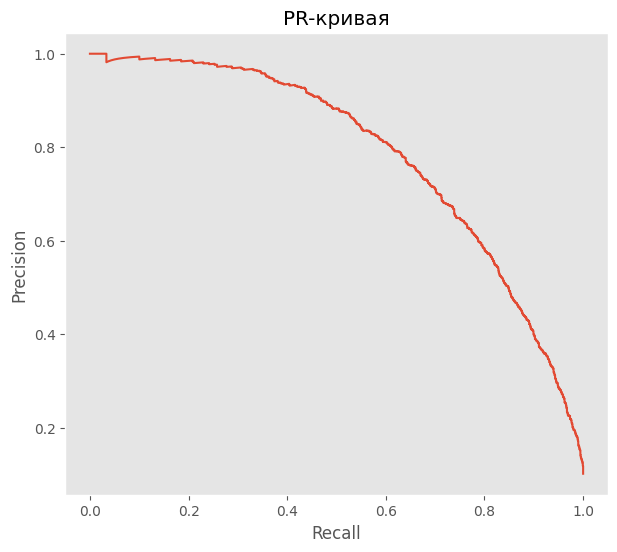

F1 = 0.665
Recall = 0.551
Precision = 0.841


In [88]:
# тестирование SentanceTranformer на CatBoost (GPU)
prediction_valid = CatBoost_gpu_emb.predict(X_valid_emb)
proba_valid = CatBoost_gpu_emb.predict_proba(X_valid_emb)
precision, recall, thresholds = precision_recall_curve(Y_valid_emb, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_emb, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_emb, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_emb, prediction_valid)))

## Итоговое тестирование

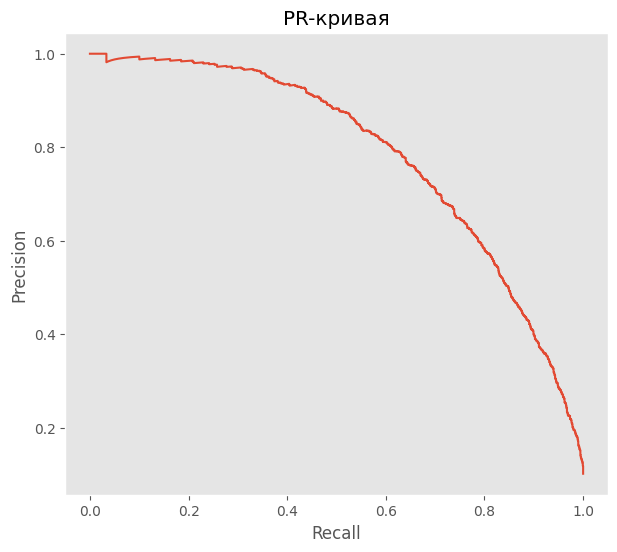

F1 = 0.781
Recall = 0.788
Precision = 0.774


In [89]:
# финальный тест TF-IDF на Logistic Regression + смещение порога классификации
proba_test = LogRer_tfidf.predict_proba(X_test_tfidf)
prediction_test = proba_test[:, 1] > 0.25
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_test_tfidf, prediction_test)))
print('Recall = {:.3f}'.format(recall_score(Y_test_tfidf, prediction_test)))
print('Precision = {:.3f}'.format(precision_score(Y_test_tfidf, prediction_test)))

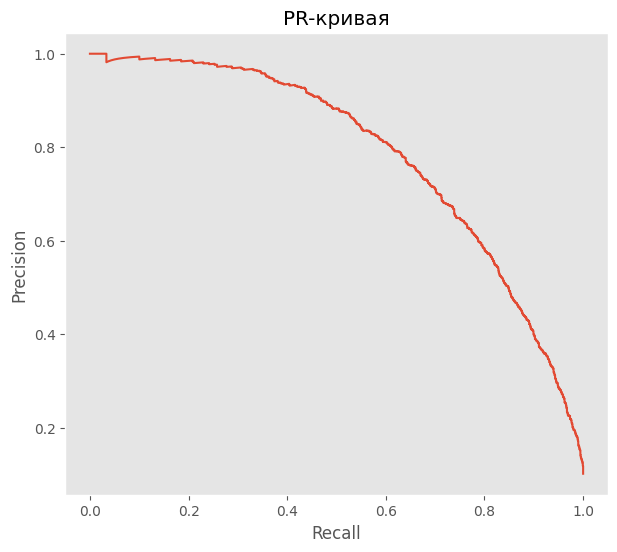

F1 = 0.769
Recall = 0.705
Precision = 0.846


In [90]:
# финальный тест TF-IDF на CatBoost + смещение порога классификации
proba_test = CatBoost_tfidf.predict_proba(X_test_tfidf)
prediction_test = proba_test[:, 1] > 0.49
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_test_tfidf, prediction_test)))
print('Recall = {:.3f}'.format(recall_score(Y_test_tfidf, prediction_test)))
print('Precision = {:.3f}'.format(precision_score(Y_test_tfidf, prediction_test)))